In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt



In [2]:
data_path = 'imputed 2007-2023 (1).csv'
df = pd.read_csv(data_path, parse_dates=['Date'])



In [3]:
# Normalisasi menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = scaler.fit_transform(np.array(df['close']).reshape(-1, 1))



In [4]:
# Pembagian data latih 90% dan data validasi 10%
training_size = int(len(df) * 0.9)
test_size = len(df) - training_size
train_data, test_data = df['close'][0:training_size], df['close'][training_size:len(df)]

In [5]:
def create_dataset(data, window_size=1):
    X, Y = [], []
    for i in range(len(data)-window_size-1):
        a = data[i:(i+window_size), 0]
        X.append(a)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [6]:
window_size = 30  # Jumlah lag untuk input
X_train, y_train = create_dataset(train_data.values.reshape(-1,1), window_size)
X_test, y_test = create_dataset(test_data.values.reshape(-1,1), window_size)



In [7]:
# Model KGBoost
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [8]:
# Pelatihan model
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [9]:

# Prediksi menggunakan model yang telah dilatih
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [10]:

# Hasil prediksi di denormalisasi ke skala aslinya
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [11]:

# Mengeluarkan output metrik evaluasi
train_mape = mean_absolute_percentage_error(y_train, train_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train MAPE: {train_mape}, Train RMSE: {train_rmse}')
print(f'Test MAPE: {test_mape}, Test RMSE: {test_rmse}')



Train MAPE: 0.085156005632398, Train RMSE: 38.63524758457795
Test MAPE: 0.03459508352508137, Test RMSE: 27.05462283207069


In [12]:
train_plot = np.empty_like(df['close'])
train_plot[:] = np.nan
train_plot[window_size:len(train_predict)+window_size] = train_predict[:,0]

test_plot = np.empty_like(df['close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(window_size*2)+1:len(df)-1] = test_predict[:,0]


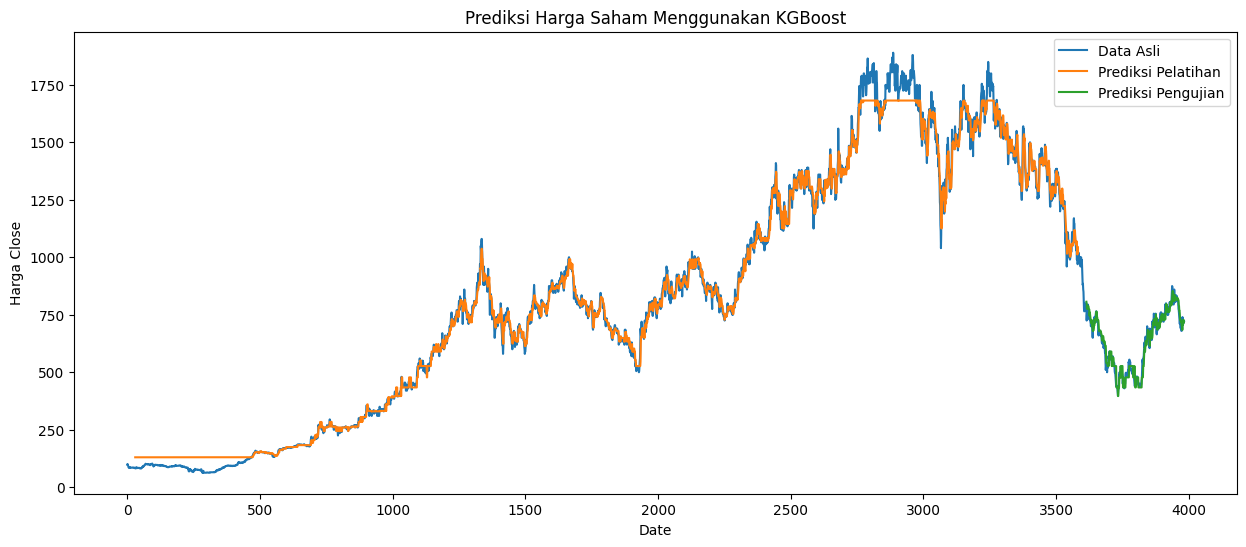

In [13]:

# Visualisasi hasil prediksi terhadap nilai asli
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['close'].values.reshape(-1, 1)), label='Data Asli')
plt.plot(train_plot, label='Prediksi Pelatihan')
plt.plot(test_plot, label='Prediksi Pengujian')
plt.xlabel('Date')
plt.ylabel('Harga Close')
plt.title('Prediksi Harga Saham Menggunakan KGBoost')
plt.legend()
plt.show()


In [14]:

result_df = df[['Date']].copy()
result_df['Actual'] = scaler.inverse_transform(df['close'].values.reshape(-1, 1))
result_df['Train_Predict'] = np.nan
result_df['Test_Predict'] = np.nan

result_df.iloc[window_size:len(train_predict) + window_size, result_df.columns.get_loc('Train_Predict')] = train_predict[:, 0]
result_df.iloc[len(train_predict) + (window_size * 2) + 1:len(df) - 1,  result_df.columns.get_loc('Test_Predict')] = test_predict[:, 0]

In [15]:
# Fungsi untuk memprediksi harga masa depan
def predict_future_prices(model, data, window_size, future_days):
    future_predictions = []
    last_window = data[-window_size:]

    for day in range(future_days):
        pred = model.predict(last_window.reshape(1, window_size))
        future_predictions.append(pred[0])
        last_window = np.append(last_window[1:], pred[0])

    return np.array(future_predictions).reshape(-1, 1)

In [16]:
# Prediksi untuk 90 hari ke depan
future_days = 90
future_predictions = predict_future_prices(model, test_data.values, window_size, future_days)


In [17]:

# Nilai prediksi di denormalisasi agar berada pada rentang asli data
future_predictions = scaler.inverse_transform(future_predictions)

future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=future_days)
future_df = pd.DataFrame({'Date': future_dates, 'Future_Predict': future_predictions.flatten()})

# Data asli dan prediksi masa depan ke dalam DataFrame
result_df = pd.concat([result_df, future_df], ignore_index=True)


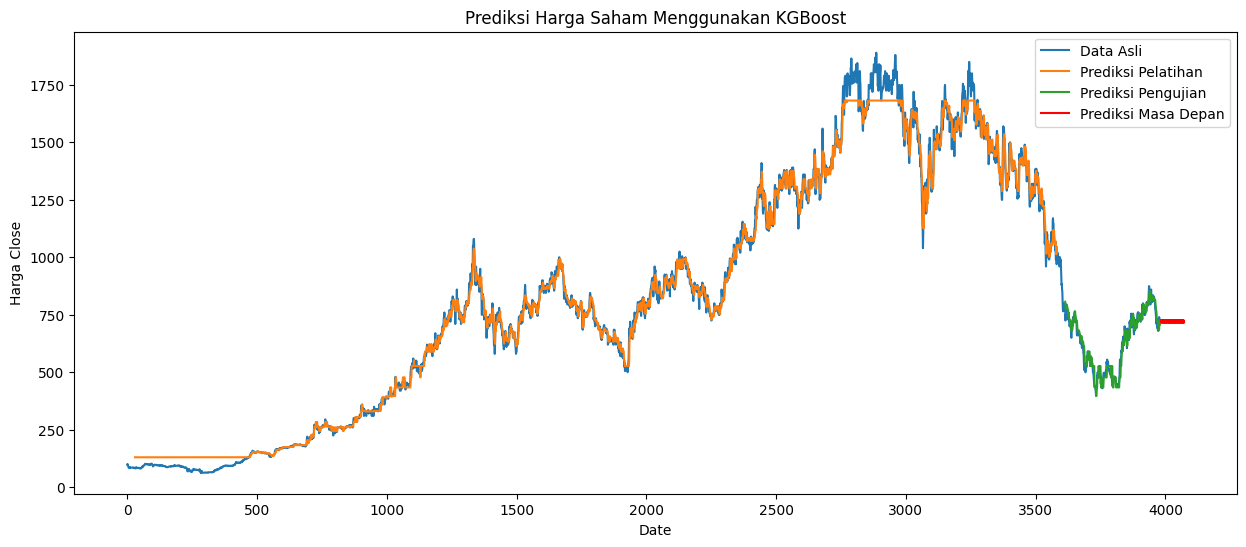

In [18]:

# Visualisasi data asli, prediksi dan nilai kedepan
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['close'].values.reshape(-1, 1)), label='Data Asli')
plt.plot(train_plot, label='Prediksi Pelatihan')
plt.plot(test_plot, label='Prediksi Pengujian')
plt.plot(np.arange(len(df), len(df) + future_days), future_predictions, label='Prediksi Masa Depan', color='red')
plt.xlabel('Date')
plt.ylabel('Harga Close')
plt.title('Prediksi Harga Saham Menggunakan KGBoost')
plt.legend()
plt.show()


In [19]:

result_df.to_csv('kgboost_prediction_90days.csv', index=False)
print('Hasil prediksi telah disimpan ke dalam file "kgboost_prediction_90days.csv".')

Hasil prediksi telah disimpan ke dalam file "kgboost_prediction_90days.csv".
